# X-Ray Image Classification

**_This notebook can be run by either running as is by training each model, or model training can be skipped. If skipping the model.fit() stages, download the pretrained models from this link and place in the root repo folder:_**

https://www.dropbox.com/sh/kwvbqq4vs0az68j/AAAT8iT-1RX8geTjGW5tCHwKa?dl=0

## Import Modules and Packages

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import random
import pickle
import boto3

#Sci-Kit Learn Modules
from skimage import color
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 
from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve

#Tensorflow Modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.compat.v1 import set_random_seed

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from tensorflow.keras import models, metrics 
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPool2D, MaxPooling2D
from tensorflow.keras.layers import Activation, BatchNormalization, Dropout, Flatten, Dense 
from tensorflow.keras.layers import Input, ReLU, LeakyReLU, Conv2DTranspose

from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import he_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision, Accuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras_tqdm import TQDMCallback

In [3]:
import time
from tqdm import tqdm_notebook as tqdm

## Read in Image Data

In [4]:
# Directory path
train_data_dir = 'xrays/train/'
test_data_dir = 'xrays/test'
val_data_dir = 'xrays/val'

# Get train images from directory xrays/train, augment, and reshape them
train_generator = ImageDataGenerator(rescale = 1.0/255.,
                                     rotation_range = 3,
                                     width_shift_range=0.05,
                                     height_shift_range = 0.05,
                                     shear_range = 0.05,
                                     zoom_range = 0.05,
                                     ).flow_from_directory(train_data_dir, 
                                                           target_size=(256, 256),
                                                           class_mode='binary',
                                                           color_mode='grayscale',
                                                           seed=42)

# Get test images from directory xrays/test, and reshape them
test_generator = ImageDataGenerator(rescale = 1.0/255.,
                                   ).flow_from_directory(test_data_dir, 
                                                         target_size=(256, 256),
                                                         class_mode='binary',
                                                         color_mode='grayscale',
                                                         shuffle = False)


# Get validation images from directory xrays/val, and reshape them
val_generator = ImageDataGenerator(rescale = 1.0/255.,
                                   ).flow_from_directory(val_data_dir, 
                                                         target_size=(256, 256),
                                                         class_mode='binary',
                                                         color_mode='grayscale',
                                                         shuffle=False)

Found 4616 images belonging to 2 classes.
Found 640 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


## Exploratory Data Analsis

### Visualizing Images in Dataset

**Previewing a few images from dataset**

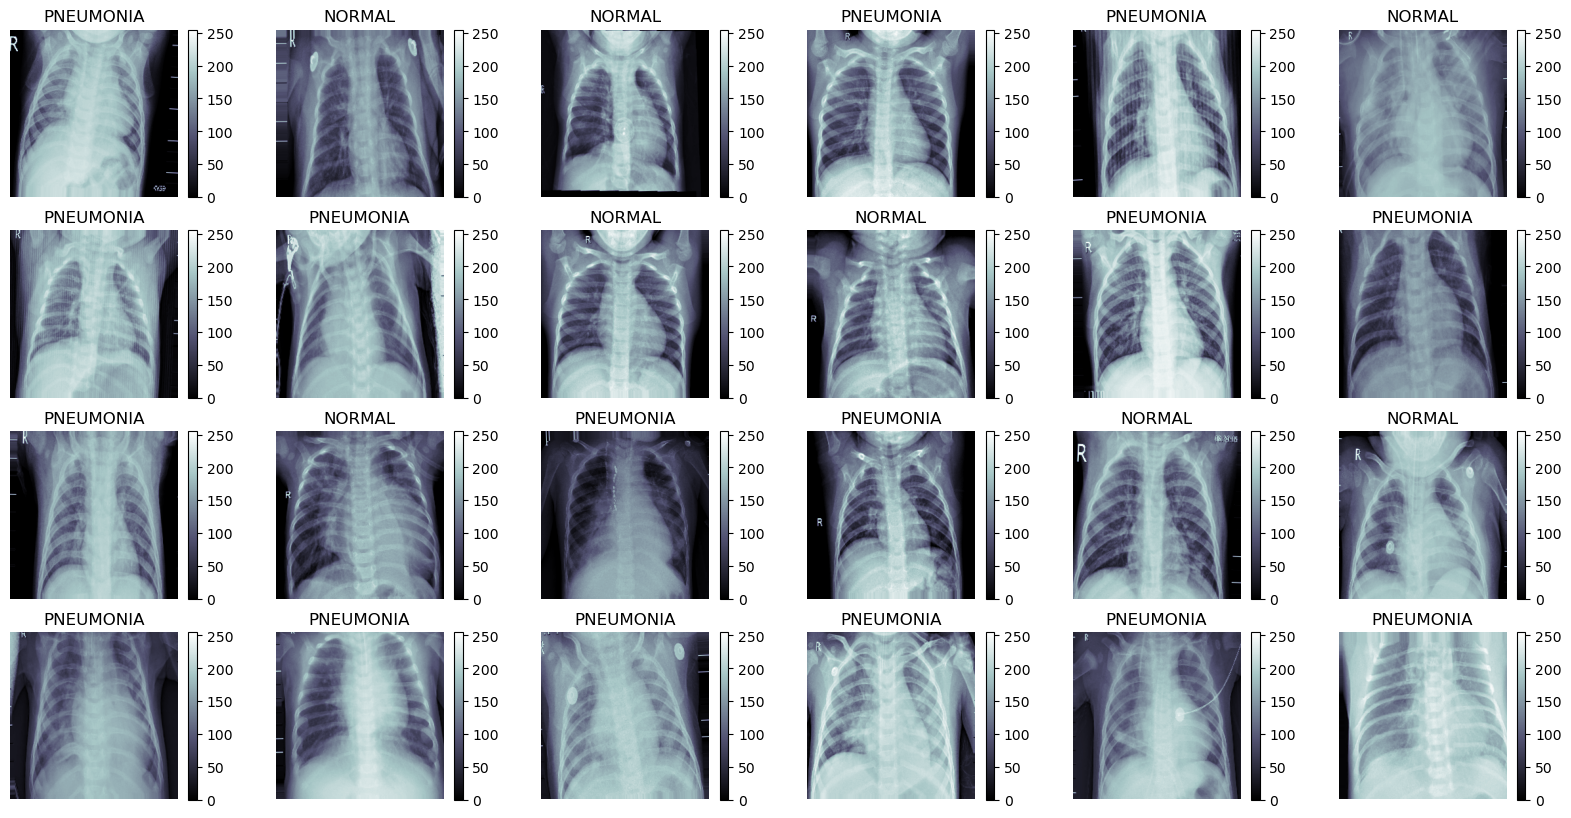

In [5]:
# Visualize Train Set
plt.style.use('default')
fig=plt.figure(figsize=(20, 10))
columns = 6; rows = 4
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]        
        dic = {0:"NORMAL", 1:"PNEUMONIA"}
        plt.title(dic.get(Y_batch[0]))
        plt.axis("off")
        plt.imshow(array_to_img(X_batch[i]), cmap=plt.cm.bone)
        plt.colorbar()
        fig.add_subplot
        break

The x-ray images of patients with pneumonia appear cloudier around the lung area. 

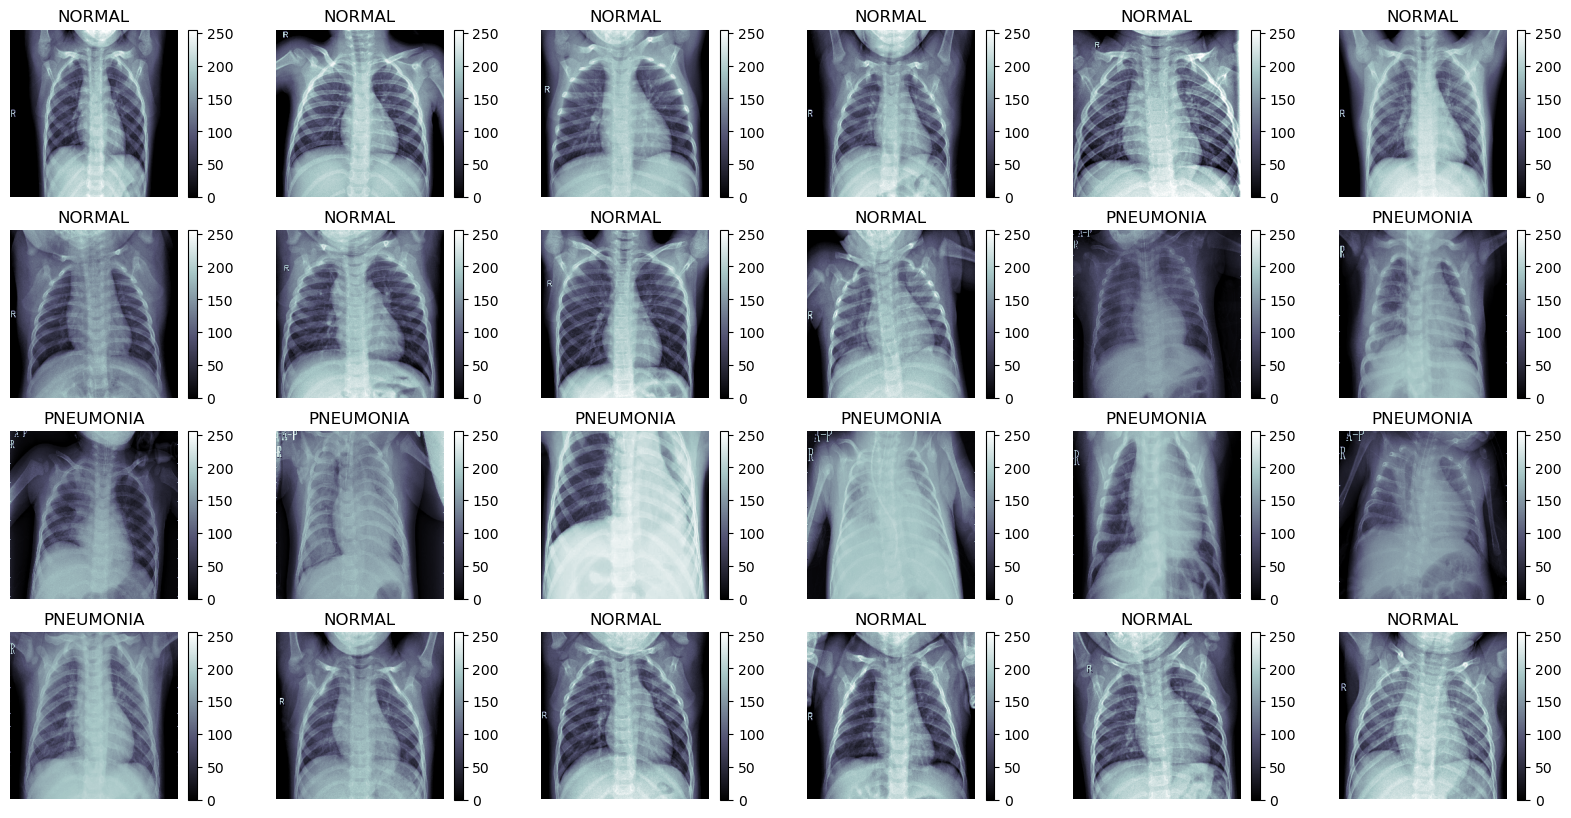

In [6]:
#Images and Labels from Validation Set

plt.style.use('default')
fig=plt.figure(figsize=(20, 10))
columns = 6; rows = 4
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    for X_batch, Y_batch in val_generator:
        image = X_batch[0]        
        dic = {0:"NORMAL", 1:"PNEUMONIA"}
        plt.title(dic.get(Y_batch[0]))
        plt.axis("off")
        plt.imshow(array_to_img(X_batch[i]), cmap=plt.cm.bone)
        plt.colorbar()
        fig.add_subplot
        break

### Visualizing Class Counts

In [7]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

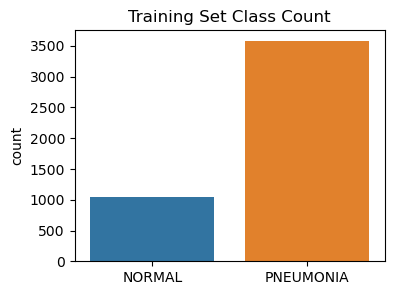

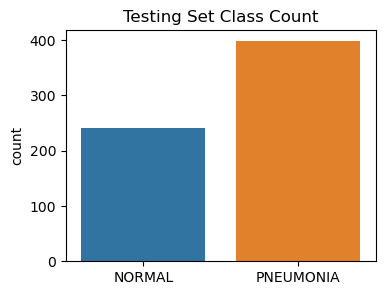

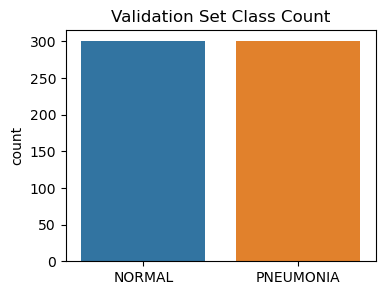

In [8]:
# Plot Class Frequency in Training, Testing, and Validation sets
train_class = train_generator.classes
test_class = test_generator.classes
val_class = val_generator.classes


a = np.where(train_class == 0, 'NORMAL', 'PNEUMONIA')
b = np.where(test_class == 0, 'NORMAL', 'PNEUMONIA')
c = np.where(val_class == 0, 'NORMAL', 'PNEUMONIA')

plt.figure(figsize=(4,3))
sns.countplot(x = a)
plt.title("Training Set Class Count")
plt.show()

plt.figure(figsize=(4,3))
sns.countplot(x = b)
plt.title("Testing Set Class Count")
plt.show()

plt.figure(figsize=(4,3))
sns.countplot(x = c)
plt.title("Validation Set Class Count")
plt.show()

The class imbalance in the training set is quite clear. In order to create a more balanced training set, we adjusted the class weights in our models.

## Dealing with Class Imbalance in Training Set

In [9]:
# set class weights using training generator classes
class_weights = dict(zip(np.unique(train_class), class_weight.compute_class_weight(class_weight = 'balanced',
                                                                               classes = np.unique(train_class),
                                                                               y = train_class))) 

These are the adjusted weights for our "0" or Normal class, and our "1" or Pneumonia class. As you can see, the weights applied to our Normal class is greater to account for the class imbalance.

## Modeling Process

## Model Q

In [66]:
# instantiate and build model
modelq = models.Sequential()

modelq.add(Conv2D(32, (3, 3), kernel_initializer=he_uniform(), activation='relu', input_shape=(256, 256, 1)))
modelq.add(MaxPooling2D((2, 2)))

modelq.add(Conv2D(64, (3, 3), kernel_initializer=he_uniform(), activation='relu'))
modelq.add(MaxPooling2D((2, 2)))

modelq.add(Conv2D(128, (3, 3), kernel_initializer=he_uniform(), activation='relu'))
modelq.add(MaxPooling2D((2, 2)))

modelq.add(Conv2D(128, (3, 3), kernel_initializer=he_uniform(), activation='relu'))
modelq.add(MaxPooling2D((2, 2)))
# flatten and send to output layer
modelq.add(Flatten())
modelq.add(Dropout(0.5))
modelq.add(Dense(512, kernel_initializer=he_uniform(), activation='relu'))
modelq.add(Dense(1, activation='sigmoid'))
# show model blueprint
modelq.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 254, 254, 32)      320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 128)      

In [ ]:
# stops model if validation loss doesn't decrease for 10 epochs
callbacks = [EarlyStopping(monitor='val_loss', patience=10),
             ModelCheckpoint(filepath='/models/model_q/best_modelq.h5', monitor='val_loss', 
                            save_best_only=True)]

In [11]:
#Compile model
compileparams = modelq.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-4), 
                               metrics=[Recall(), Precision(),'acc'])
#Fit the model to Training Set and Validate on Validation set
history_q = modelq.fit(train_generator, 
                      validation_data=val_generator,
                      steps_per_epoch= 144,
                      epochs=50,
                      class_weight = class_weights,
                      verbose = 2,
                      callbacks = [callbacks, TqdmCallback()])

In [10]:
# define model saving function 
def save_model(model, history, model_name):
    # check model has been run 
    try:
        history
    except NameError:
        return "Model hasn't been properly run"
    
    # save model to JSON
    model_json = model.to_json()
    with open(f"models/{model_name}/{model_name}.json", "w") as json_file:
        json_file.write(model_json)

    # save weights to HDF5
    model.save_weights(f"models/{model_name}/{model_name}_weights.h5")
    print("Saved model to disk")
    modelz.save(f'{model_name}.h5')  # creates a HDF5 file 

    #pickle model history
    with open(f'models/{model_name}/{model_name}trainHistoryDict.pickle', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

    # convert the history.history dict to a pandas DataFrame:     
    modelz_hist_df = pd.DataFrame(history.history) 

    #save to csv: 
    with open(f'models/{model_name}/{model_name}_history.csv', mode='w') as f:
        modelz_hist_df.to_csv(f)

In [ ]:
# save_model(modelq, history_q, "model_q")

### Plotting Validation Accuracy and Loss for Model Q

In [10]:
# define visualization function
def plot_model(history, epochs):
    # allow either imported history or direct history to run 
    if type(history_q) != pd.core.frame.DataFrame:
        history = history.history
    
    # set graph style
    plt.style.use('seaborn-dark')
    fig = plt.figure(figsize=(16,6))
    
    #visualize loss
    ax1 = fig.add_subplot(121)
    plt.plot(range(1, epochs+1), history['loss'], label='train loss')
    plt.plot(range(1, epochs+1), history['val_loss'], label= 'val loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('number of epochs')
    plt.legend()
    
    # visualize accuracy
    ax2 = fig.add_subplot(122)
    plt.plot(range(1, epochs+1), history['acc'], label = 'train acc')
    plt.plot(range(1, epochs+1), history['val_acc'], label = 'val acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('number of epochs')
    plt.legend()

In [11]:
# import history if model wasn't fit
try:
    history_q
except NameError:
    history_q = pd.read_csv('models/model_q/model_q_history.csv', index_col='Unnamed: 0')

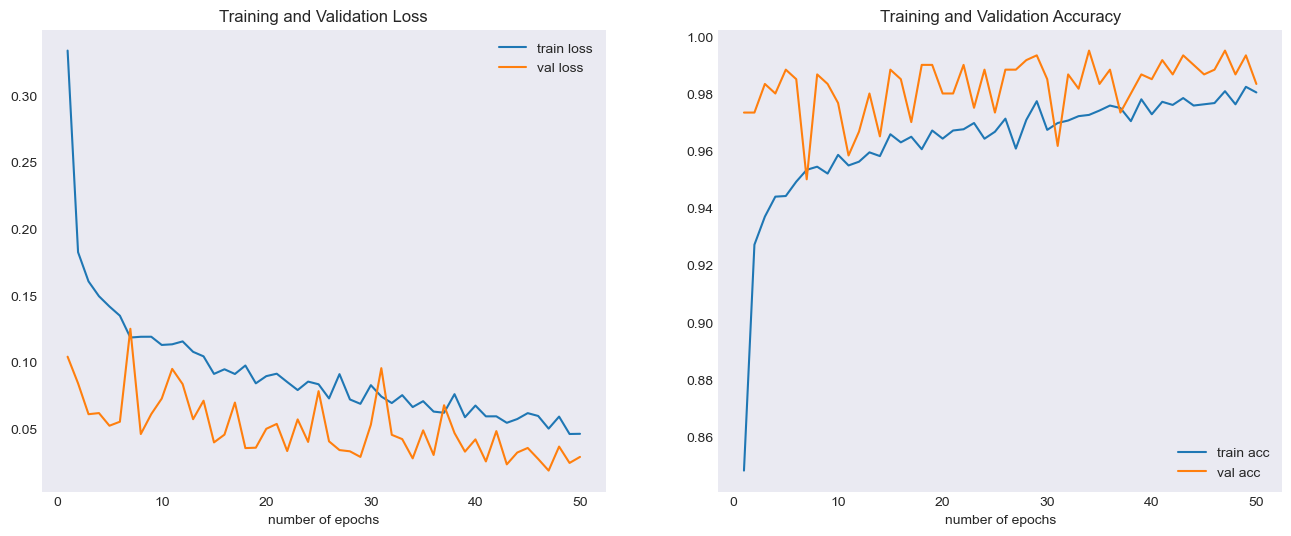

In [12]:
# plot model q
plot_model(history_q, 50)

### Confusion Matrix for Model Q

**Predict on test set**

In [13]:
# load saved model if model wasn't run
if type(history_q) == pd.core.frame.DataFrame:
    modelq = tf.keras.models.load_model('models/model_q/model_q.h5')
# set variable with ground truth
y_true = test_generator.classes
# define function for confusion matrix plot
def model_conf(model, history):

    # make predictions on test set       
    y_pred = model.predict(test_generator) > 0.5
    
    # create raw confusion matrix 
    cm_q = confusion_matrix(y_true, y_pred)
    # create visualization for confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_q, display_labels=["Normal", "Pneumonia"])
    disp.plot(cmap='Blues')
    plt.show()
    
    return y_pred

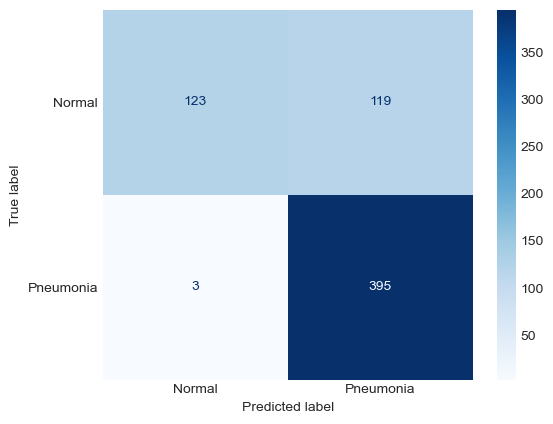

In [14]:
# create confusion matrix with Model Q
y_pred_q = model_conf(modelq, history_q)

## Viewing Missed Casses

In [15]:
# create list containing image arrays and ground truth 
Xs = []
ys = []
for i in range(20):
    batch = next(test_generator)
    Xs.extend(batch[0])
    ys.extend(batch[1])

In [16]:
# define function to fetch a false positive and false negative 
def miscategorized(y_pred):
    # create array for missed predictions
    miss_class = y_pred.squeeze() != y_true.squeeze()
    # get missed classes idx
    missed_idx = [idx for idx, y in enumerate(miss_class) if y]
    # make list of missclassified image arrays
    missed_xray = [(X, y) for idx, (X, y) in enumerate(zip(Xs, ys)) if idx in missed_idx]
    
    # pick false positive
    FP = [i for i, idx in enumerate(missed_idx) if y_pred[idx] == True]
    fp_idx = random.choice(FP)
    # verify false positive
    i = 0
    while missed_xray[fp_idx][1] == y_pred[missed_idx[fp_idx]]:
        fp_idx = random.choice(FP)
        i += 1
        if i > 100:
            return "False Positive Error"
    # store false positive example
    fp_img = array_to_img(Xs[fp_idx])
    
    # pick false negative
    FN = [i for i, idx in enumerate(missed_idx) if y_pred[idx] == False]
    fn_idx = random.choice(FN)
    # verify false negative
    i = 0
    while missed_xray[fn_idx][1] == y_pred[missed_idx[fn_idx]]:
        fn_idx = random.choice(FN)
        i += 1
        if i > 100:
            return "False Negative Error"
    # store false negative example
    fn_img = array_to_img(Xs[fn_idx])
    
    return fp_img, fn_img

Example 1

False Positive:


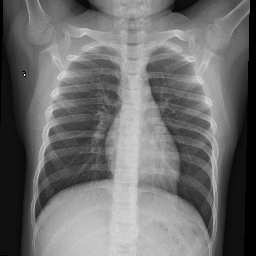

In [17]:
# call function and display false positive
fp_q, fn_q = miscategorized(y_pred_q)
print('False Positive:')
fp_q

False Negative:


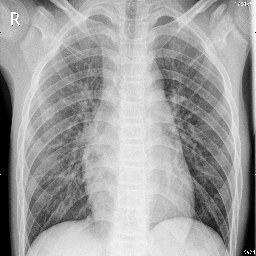

In [18]:
# call false negative
print('False Negative:')
fn_q

### Evaluating Model Q's Performance on Test Set

Accuracy, precision, and recall are used as metrics to quantify correctly categorized images, false positves, and false negatives 

In [19]:
# define function to show evaluation metrics
def score_it(model):
    score = model.evaluate(test_generator, verbose=0)
    print(f'Model Loss:      {round(score[0],2)} \nModel Accuracy:  {round(score[3],2)}')
    print(f'Model Recall:    {round(score[1],2)} \nModel Precision: {round(score[2],2)}')
    
    return round(score[3],3)

In [20]:
score_q = score_it(modelq)

Model Loss:      0.92 
Model Accuracy:  0.81
Model Recall:    0.99 
Model Precision: 0.77


ROC Curve

In [21]:
# define function to plot an ROC-AUC curve 
def plot_roc_curve(model):
    # get predicted probabilities
    y_val_prob = model.predict(test_generator)
    # call roc function
    fpr, tpr, thresholds = roc_curve(test_generator.classes , y_val_prob)
    
    # plot curve 
    plt.plot(fpr,tpr)  
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    plt.plot([0,1], [0,1])
    plt.show()    
    # return score
    return roc_auc_score(test_generator.classes, y_val_prob) 

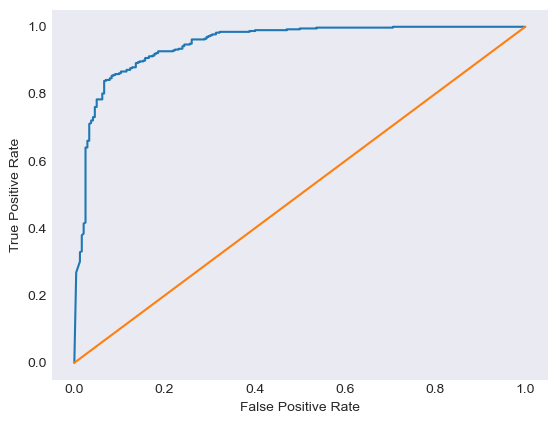

0.9480408239544831

In [22]:
plot_roc_curve(modelq) 

## Model R — Minor Changes (The Winner)

In [38]:
# other attempted model structure
modelr = models.Sequential()

modelr.add(Conv2D(32, (7, 7), kernel_initializer=he_uniform(), kernel_regularizer=l2(), padding = "same", activation='relu', input_shape=(256, 256, 1)))
modelr.add(MaxPooling2D((2, 2)))

modelr.add(Conv2D(64, (3, 3), kernel_initializer=he_uniform(), kernel_regularizer=l2(), padding = "same", activation='relu'))
modelr.add(MaxPooling2D((2, 2)))

modelr.add(Conv2D(128, (3, 3), kernel_initializer=he_uniform(), kernel_regularizer=l2(), padding = "same", activation='relu'))
modelr.add(MaxPooling2D((2, 2)))

modelr.add(Conv2D(128, (3, 3), kernel_initializer=he_uniform(), kernel_regularizer=l2(), padding = "same", activation='relu'))
modelr.add(MaxPooling2D((2, 2)))

modelr.add(Conv2D(256, (3, 3), kernel_initializer=he_uniform(), kernel_regularizer=l2(), padding = "same", activation='relu'))
modelr.add(MaxPooling2D((2, 2)))

modelr.add(Conv2D(256, (3, 3), kernel_initializer=he_uniform(), kernel_regularizer=l2(), padding = "same", activation='relu'))
modelr.add(MaxPooling2D((2, 2)))

modelr.add(Flatten())
modelr.add(Dropout(0.5))
modelr.add(Dense(512, kernel_initializer=he_uniform(), activation='relu'))
modelr.add(Dense(1, activation='sigmoid'))

modelr.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      1600      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       1

In [ ]:
# stops model if validation loss doesn't decrease for 10 epochs
callbacks = [EarlyStopping(monitor='val_loss', patience=10),
             ModelCheckpoint(filepath='/models/model_r/best_modelr.h5', monitor='val_loss', 
                            save_best_only=True)]

In [ ]:
#Compile model
modelr.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-4), metrics=[Recall(), Precision(),'acc'])

#Fit the model to Training Set and Validate on Validation set
history_r = modelr.fit(train_generator, 
                      validation_data = val_generator,
                      steps_per_epoch = 144,
                      epochs=100,
                      class_weight = class_weights,
                      verbose = 2,
                      callbacks = [callbacks, TqdmCallback()])

In [ ]:
# save_model(modelr, history_r, "model_r")

### Plotting Validation Accuracy and Loss for Model R

In [23]:
# import history if model wasn't fit
try:
    history_r
except NameError:
    history_r = pd.read_csv('models/model_r/model_r_history.csv', index_col='Unnamed: 0')

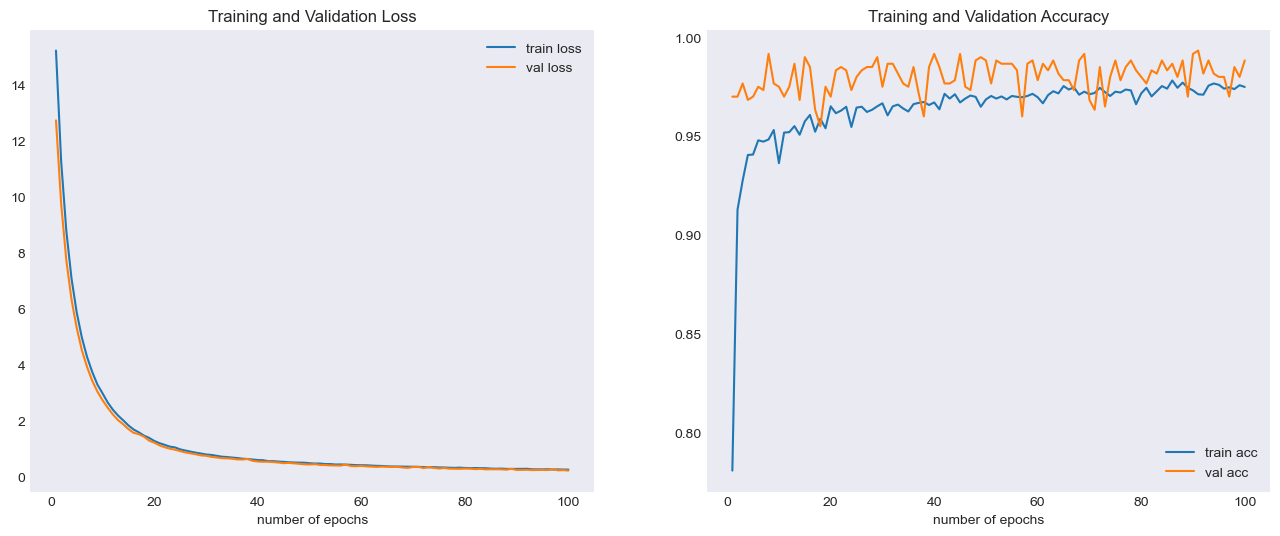

In [24]:
# plot performance for each epoch
plot_model(history_r, 100)

### Confusion Matrix for Model R

**Predict on test set**

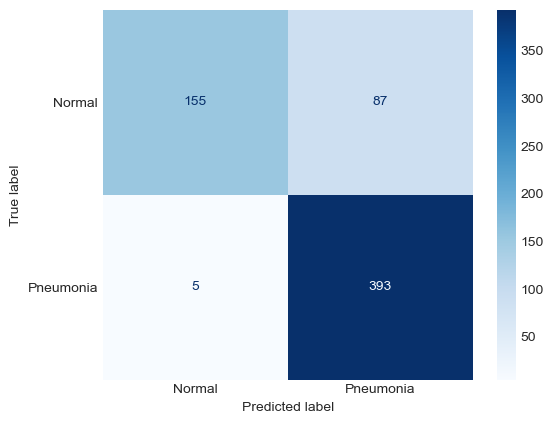

In [25]:
# load model if model not run
if type(history_r) == pd.core.frame.DataFrame:
    modelr = tf.keras.models.load_model('models/model_r/model_r.h5')
# plot confusion matrix
y_pred_r = model_conf(modelr, history_r)

False Positive:


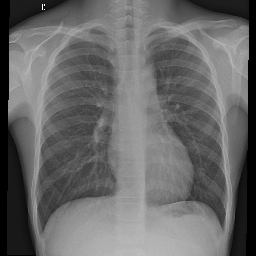

In [26]:
# call function and display false positive example
fp_r, fn_r = miscategorized(y_pred_r)
print('False Positive:')
fp_r

False Negative:


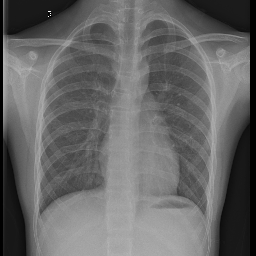

In [27]:
# display false negative
print('False Negative:')
fn_r

### Evaluating Model R's Performance on Test Set

In [28]:
# call evaluation function
score_r = score_it(modelr)

Model Loss:      0.7 
Model Accuracy:  0.86
Model Recall:    0.99 
Model Precision: 0.82


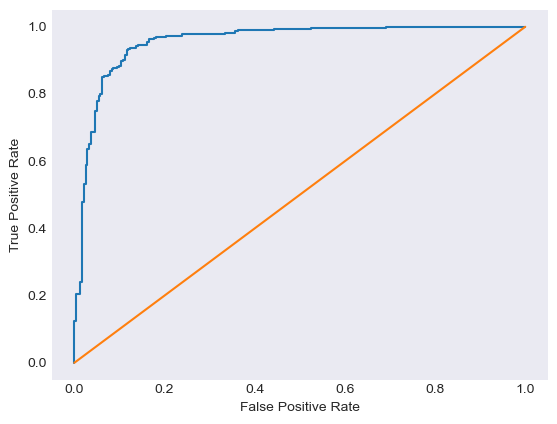

0.9554072012957349

In [29]:
# plot ROC-AUC curve
plot_roc_curve(modelr)

## Model T — Added Normalization and Complexity

In [30]:
# doubled layers
modelt = models.Sequential()


modelt.add(Conv2D(16, (3, 3), kernel_initializer=he_uniform(), activation='relu', padding='same',input_shape=(256, 256, 1)))
modelt.add(Conv2D(16, (3, 3), kernel_initializer=he_uniform(), activation='relu', padding='same'))
modelt.add(MaxPool2D((2, 2)))


modelt.add(SeparableConv2D(32, (3, 3), kernel_initializer=he_uniform(), activation='relu', padding='same'))
modelt.add(SeparableConv2D(32, (3, 3), kernel_initializer=he_uniform(), activation='relu', padding='same'))
modelt.add(BatchNormalization())
modelt.add(MaxPool2D((2, 2)))


modelt.add(SeparableConv2D(64, (3, 3), kernel_initializer=he_uniform(), activation='relu', padding='same'))
modelt.add(SeparableConv2D(64, (3, 3), kernel_initializer=he_uniform(), activation='relu', padding='same'))
modelt.add(BatchNormalization())
modelt.add(MaxPool2D((2, 2)))


modelt.add(SeparableConv2D(128, (3, 3), kernel_initializer=he_uniform(), activation='relu', padding='same'))
modelt.add(SeparableConv2D(128, (3, 3), kernel_initializer=he_uniform(), activation='relu', padding='same'))
modelt.add(BatchNormalization())
modelt.add(MaxPool2D((2, 2)))
modelt.add(Dropout(rate=0.2))


modelt.add(SeparableConv2D(256, (3, 3), kernel_initializer=he_uniform(), activation='relu', padding='same'))
modelt.add(SeparableConv2D(256, (3, 3), kernel_initializer=he_uniform(), activation='relu', padding='same'))
modelt.add(BatchNormalization())
modelt.add(MaxPool2D((2, 2)))
modelt.add(Dropout(0.2))


modelt.add(Flatten())
modelt.add(Dense(512, kernel_initializer=he_uniform(), activation='relu'))
modelt.add(Dropout(0.5))
modelt.add(Dense(128, kernel_initializer=he_uniform(), activation='relu'))
modelt.add(Dropout(0.5))
modelt.add(Dense(64, kernel_initializer=he_uniform(), activation='relu'))
modelt.add(Dropout(0.3))

modelt.add(Dense(1, activation='sigmoid'))
   
    
modelt.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 16)      160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 128, 128, 32)      688       
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 128, 128, 32)      1344      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0

In [ ]:
# stops model if validation loss doesn't decrease for 10 epochs
callbacks = [EarlyStopping(monitor='val_loss', patience=10),
             ModelCheckpoint(filepath='/models/model_t/best_modelt.h5', monitor='val_loss', 
                            save_best_only=True)]

In [ ]:
#Compile model 
modelt.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-4), metrics=[Recall(), Precision(),'acc'])

#Fit the model to Training Set and Validate on Validation set
history_t = modelt.fit(train_generator, 
                       validation_data=(val_generator),
                       steps_per_epoch= 144,
                       epochs=50,
                       class_weight = class_weights,
                       verbose = 2,
                       callbacks = [callbacks, TqdmCallback()])

In [ ]:
# save_model(modelr, history_r, "model_r")

In [31]:
# import history if model wasn't fit
try:
    history_t
except NameError:
    history_t = pd.read_csv('models/model_t/model_t_history.csv', index_col='Unnamed: 0')

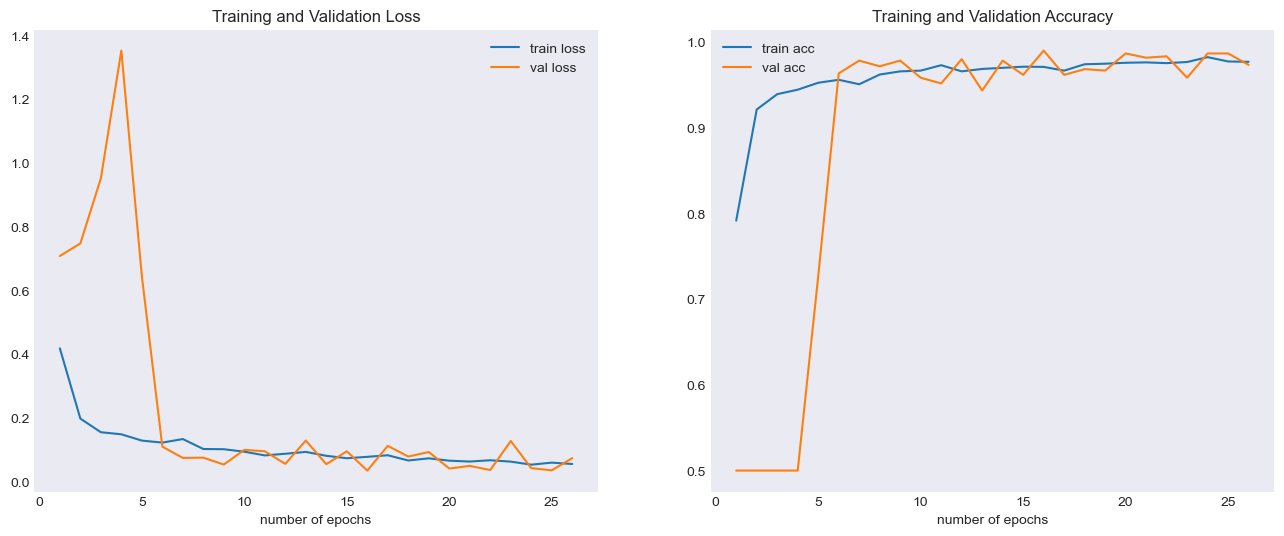

In [32]:
# plot performance for each epoch
plot_model(history_t, 26)

### Confusion Matrix for Model T

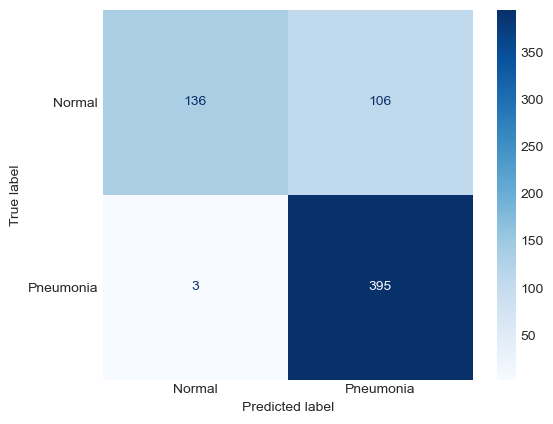

In [33]:
# load saved model if model wasn't fit 
if type(history_t) == pd.core.frame.DataFrame:
    modelt = tf.keras.models.load_model('models/model_t/model_t.h5')
# plot confusion matrix
y_pred_t = model_conf(modelt, history_t)

### Looking at Miscategorized images

False Positive:


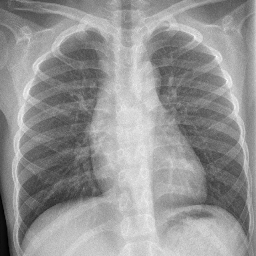

In [34]:
# call function and display false positive example
fp_t, fn_t = miscategorized(y_pred_t)
print('False Positive:')
fp_t

False Negative:


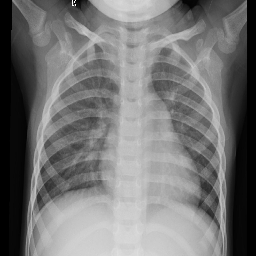

In [35]:
# display false negative
print('False Negative:')
fn_t

### Evaluating Model T's Performance on Test Set

In [36]:
# call evaluation function
score_t = score_it(modelt)

Model Loss:      0.75 
Model Accuracy:  0.83
Model Recall:    0.99 
Model Precision: 0.79


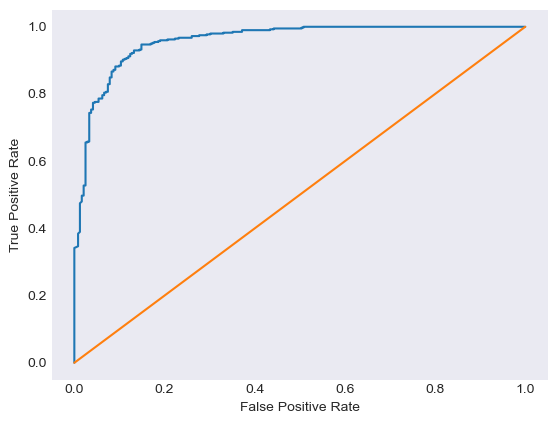

0.9584181236762324

In [37]:
# plot ROC-AUC curve
plot_roc_curve(modelt)

## Model Z — Regularization and Tweaked Layer Blueprint

In [81]:
# model with regularization
modelz = models.Sequential()
# Trying larger convultional filter
modelz.add(Conv2D(32, (7,7), kernel_initializer=he_uniform(), kernel_regularizer=l2(), activation='relu', input_shape=(256, 256, 1)))
modelz.add(MaxPooling2D(2,2))

modelz.add(Conv2D(32, (3,3), kernel_initializer=he_uniform(), kernel_regularizer=l2(), activation='relu'))
modelz.add(MaxPooling2D(2,2))

modelz.add(Conv2D(128,(3,3), kernel_initializer=he_uniform(), activation='relu'))
modelz.add(MaxPooling2D(2,2))

modelz.add(Conv2D(64,(3,3), kernel_initializer=he_uniform(), activation='relu'))
modelz.add(MaxPooling2D(2,2))

modelz.add(Conv2D(128,(3,3), kernel_initializer=he_uniform(), activation='relu'))
modelz.add(MaxPooling2D(2,2))

modelz.add(Conv2D(128,(3,3), kernel_initializer=he_uniform(), activation='relu'))
modelz.add(MaxPooling2D(2,2))
    

modelz.add(Flatten())
modelz.add(Dense(128, kernel_initializer=he_uniform(), activation='relu'))
modelz.add(Dropout(0.5))

modelz.add(Dense(1, activation='sigmoid'))

modelz.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 250, 250, 32)      1600      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 125, 125, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 123, 123, 32)      9248      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 59, 59, 128)       36992     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 29, 29, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 27, 27, 64)       

In [ ]:
# stops model if validation loss doesn't decrease for 10 epochs
callbacks = [EarlyStopping(monitor='val_loss', patience=10),
             ModelCheckpoint(filepath='/models/model_z/best_modelz.h5', monitor='val_loss', 
                            save_best_only=True)]

In [ ]:
#Compile model 
modelz.compile(Adam(lr=1e-6),loss = 'binary_crossentropy', metrics=[Recall(), Precision(),'acc'])

#Fit the model to Training Set and Validate on Validation set
history_z = modelz.fit(train_generator,
                       validation_data =(val_generator),
                       epochs = 17,
                       steps_per_epoch=144
                       class_weight=class_weights,
                       verbose = 2,
                       callbacks = [callbacks, TqdmCallback()])

In [ ]:
# save_model(modelz, history_z, "model_z")

### Plotting Validation Accuracy and Loss for Model Z

In [38]:
# import history if model wasn't fit
try:
    history_z
except NameError:
    history_z = pd.read_csv('models/model_z/model_z_history.csv', index_col='Unnamed: 0')

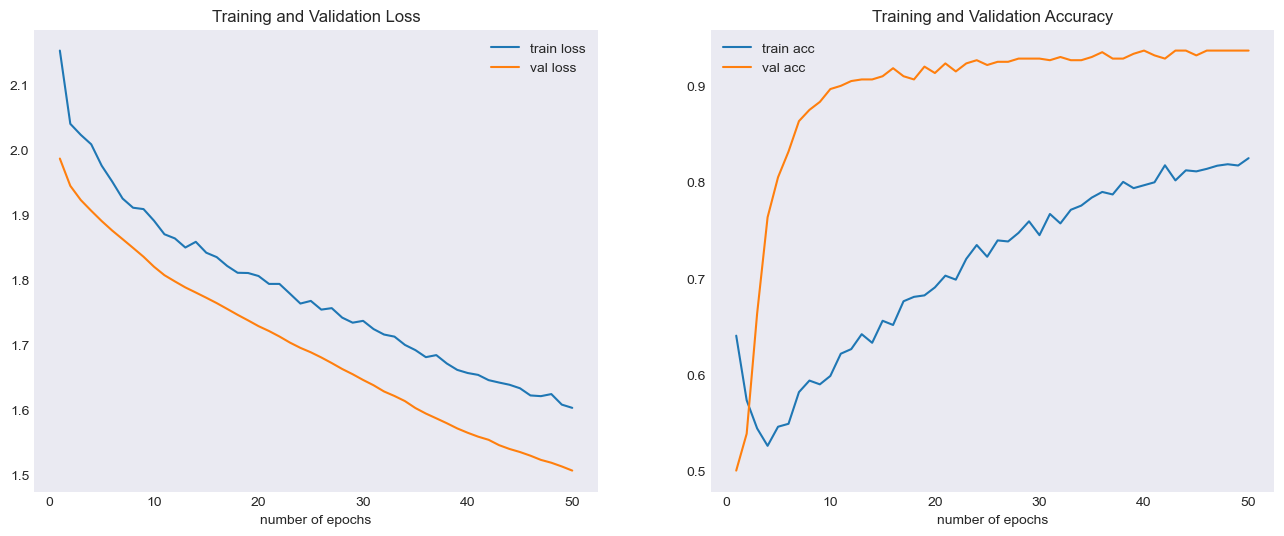

In [39]:
# plot performance for each epoch
plot_model(history_z, 50)

### Confustion Matrix for Model Z

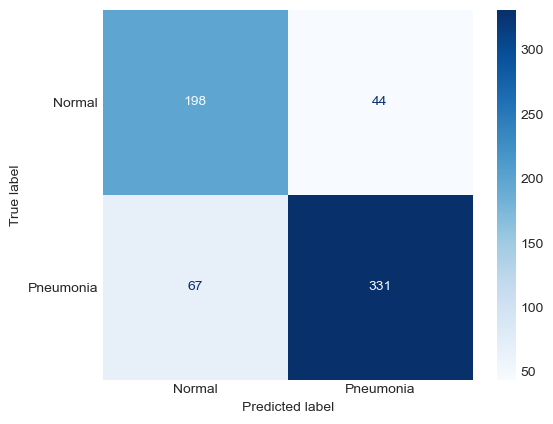

In [40]:
# load saved model if model wasn't fit 
if type(history_z) == pd.core.frame.DataFrame:
    modelz = tf.keras.models.load_model('models/model_z/model_z.h5')
# plot confusion matrix
y_pred_z = model_conf(modelz, history_z)

### Check Misclassified Images

False Positive:


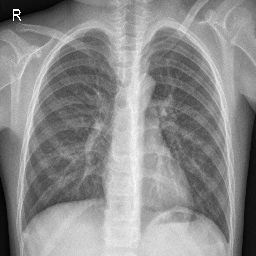

In [41]:
# call function and display false positive example
fp_z, fn_z = miscategorized(y_pred_z)
print('False Positive:')
fp_z

False Negative:


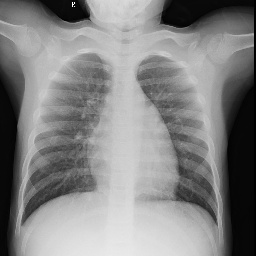

In [42]:
# display false negative
print('False Negative:')
fn_z

### Evaluating Model Z's Performance on Test Set

In [43]:
# call evaluation function
score_z = score_it(modelz)

Model Loss:      1.65 
Model Accuracy:  0.83
Model Recall:    0.83 
Model Precision: 0.88


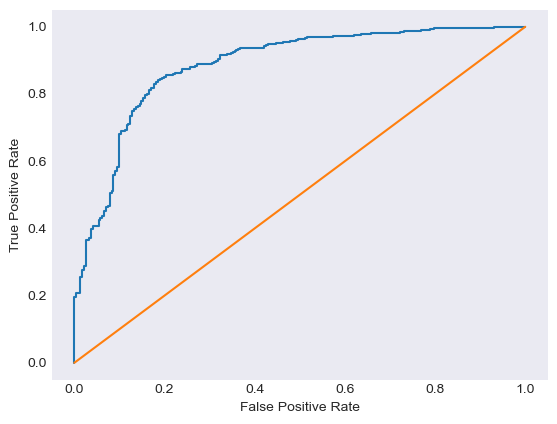

0.8849308526101584

In [44]:
# plot ROC-AUC curve
plot_roc_curve(modelz)

### Compare Accuracy of All Models

In [45]:
print(f'Model Q Accuracy: {score_q} \n\nModel R Accuracy: {score_r}')
print(f'\nModel T Accuracy: {score_t} \n\nModel Z Accuracy: {score_z}') 

Model Q Accuracy: 0.809 

Model R Accuracy: 0.856

Model T Accuracy: 0.83 

Model Z Accuracy: 0.827
